# "Cooperation Among Cancer Cells as Public Goods Games on Voronoi Networks"

#### This notebook reimpliments and explores the results given by Archetti in his paper on cooperation among cancer cells in voronoi networks.

## Structure of the Notebook

### Implimentation of the game

#### * Imports/Dependencies for the notebook
#### * Load graph file from observed cancer network + Label 5% as non-producers
#### * Displaying the graph 
#### * Defining Archetti's Payoff Functions
#### * Calculating Benefit based on Payoff Functions (I)
#### * Defining Update Rules
#### * Running the game with default parameters
______
#### * Defining and Explaining the "Parameter sheet"

### Replicating Archetti's results

#### 3.2 - Effect of costs and benefits
#### 3.3 - Effect of diffusion gradient
#### 3.4 - Peturbation of the inflection point

### Concluding Remarks





In [1]:
import numpy as np
from random import randint
import matplotlib as plt
import pylab as pl
import math
from matplotlib import collections  as mc
import scipy.sparse
import copy
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'plt', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


##### We start by importing the graph from a pre-made vornoi diagram


##### We then randomly select 5% of the nodes in the graph to be producers 

In [2]:
#===============================================================
#                   LOAD AND LABEL GRAPH
#===============================================================

# Importing the Graph
reproduction_graph = np.load("graph/interaction_graph.npy")
vertices = np.load("graph/vertex_list.npy")
edge_list = np.load("graph/edge_list.npy")
edges = np.load("graph/edges.npy")


# Random selection of non-producers
non_producers_needed = int(0.05 * len(vertices))
strategy_vector = np.ones(len(vertices))
for i in range(non_producers_needed):
    strategy_vector[randint(len(vertices))] = 0
    
ORIGINAL_STRATEGY_VECTOR = np.copy(strategy_vector)

###### We run the Floyd Warshall algorithm to get the all-pairs shortest path matrix

In [3]:
#===============================================================
#       CREATE DISTANCE GRAPH FROM REPRODUCTION GRAPH
#===============================================================
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
plt.clf()
plt.imshow(distance_graph, cmap='jet', interpolation='nearest')
plt.show()


##### We define a function to show the graph based on the current strategy vector

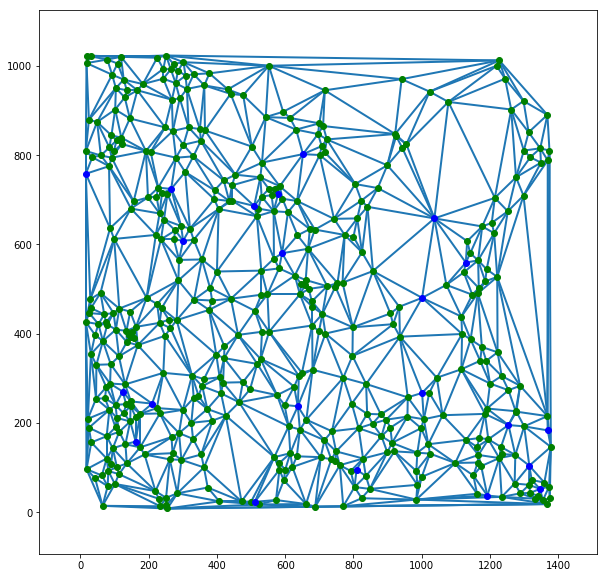

In [4]:
#===============================================================
#   DISPLAY GRAPH FUNCTION -> RELYS ON GLOBAL GRAPH STRUCTURE
#===============================================================
def display_graph(strategy_vector):
    edges = [[(vertices[i[0]][0], vertices[i[0]][1]), (vertices[i[1]][0], vertices[i[1]][1])] for i in edge_list]
    lc = mc.LineCollection(edges, linewidths=2)
    fig, ax = pl.subplots()
    ax.add_collection(lc)
    plt.ion()
    ind = 0
    for i in vertices:
        if(strategy_vector[ind] == 0):
            plt.plot(i[0],i[1],'bo')
        else:
            plt.plot(i[0],i[1],'go')
        ind+=1
    ax.autoscale()
    ax.margins(0.1) 
    plt.show()
    
display_graph(strategy_vector)

##### We define the gradient function's as in Archetti's paper

g(i) --> logisitic function reliant on four parameters


G(i) --> 1 - [g(i) - g(0)/g(D) - g(0)]

In Archetti's words, here are what each of the parameters control:

* z_VALUE - "controls the steepness of the gradient at the inflection point"
* d_VALUE - "determine the shape of the diffusion gradient"
* D_VALUE - "determine the shape of the diffusion gradient"
* i - amount of production you feel

Other notes:

* (d=D), convex
* (d < D) or sigmoid 


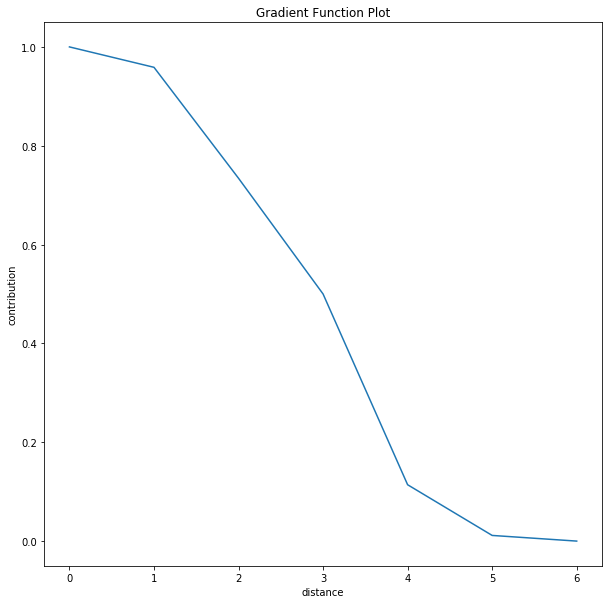

In [5]:
#===============================================================
#     DEFINE THE ARCHETTI CALCULATIONS FOR CELL BENEFIT G(i)
#===============================================================
#Params for the parameter sheet - this will be explained later
z_VALUE = 10
d_VALUE = 3
D_VALUE = 6


def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)

def gradient_function(distance):
    return 1 - ((g(distance) - g(0)) / (g(D_VALUE) - g(0)))

gf = np.vectorize(gradient_function)

value = []
for i in range(7):
    value.append(gradient_function(i))
plt.clf()
plt.title("Gradient Function Plot")
plt.xlabel("distance")
plt.ylabel("contribution")
plt.plot(value)
plt.show()


##### Using the above diffusion gradient, we define the payoff function

v(j) --> logistic helping function which relys on four variables



payoff_function --> v(j) - v(0)/v(n) - v(0)


In Archetti's words here is what each of the parameters control:

* n_VALUE --> depends on the diffusion range and gradient of the growth factor
* k_VALUE --> controls the position of the inflection point
* s_VALUE --> controls the steepness of the function at the inflection point
* j --> The amount you feel all of the producers in your group


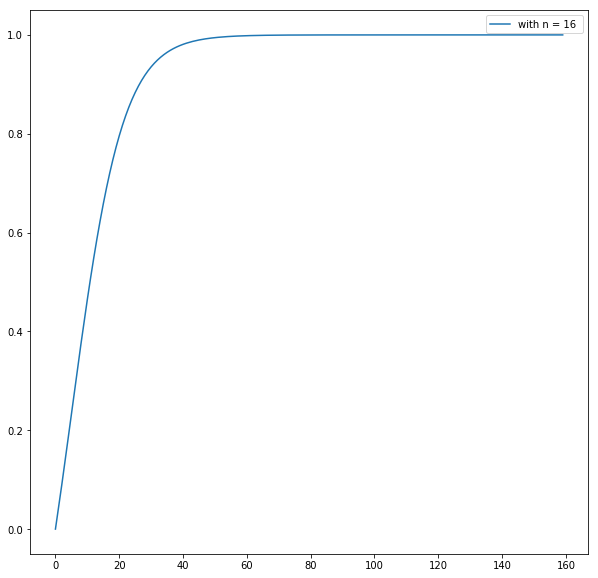

In [23]:
s_VALUE = 20
k_VALUE = .5
#n_VALUE =  1 #6 * d_VALUE #number of people in the group * the cutoff


def v(j, n, s=s_VALUE, k = k_VALUE):
    valA = (-s*(j-k))/n
    exp = math.exp(1)**valA
    return 1/(1 + exp) 

def payoff_function(i, strategy_vector, interaction_graph):  
    n_array = interaction_graph[i]
    j_array = np.multiply(n_array, strategy_vector)
    #assert(not(np.array_equal(n_array, j_array)))
    n = np.count_nonzero(j_array)
    j = sum(j_array)
    return (v(j,n)-v(0,n))/(v(n,n) - v(0,n))
    #return (v(j)-v(0))/(v(n) - v(0))

plt.clf()
values = []
handles = []

test_n = 16
for j in range(0,160):
    frac_j = float(j)
    frac_j/=10
    values.append((v(frac_j, test_n)-v(0,test_n))/(v(test_n,test_n)-v(0,test_n)))
title = "with n = %s "%(test_n)
handle, = plt.plot(values, label=title)
handles.append(handle)
values = []
plt.legend(handles=handles)
plt.show() 

#### Using both the diffusion gradient and the benefit functions:

We start by formatting the distance graph in the following ways

* Enforcing the cutoff --> Any value in the distance graph above the cutoff gets an arbitrarily large value (so it can no longer contribute)

* Enforcing non-self contributions --> any value in the distance graph that is 0 (i.e. your distance to yourself) we set the value to an arbitrarily large value (so it can no longer contribute)


Based on these values we apply the diffusion gradient function so that we can get the proper contribution of each cell to those within the diffusion range.

Once we know how much each cell contributes to every other cell, we calculate the benefit of each cell using our function above. 

Finally, we adjust the benefit vector by subtracting the cost of production.

<type 'numpy.ndarray'>


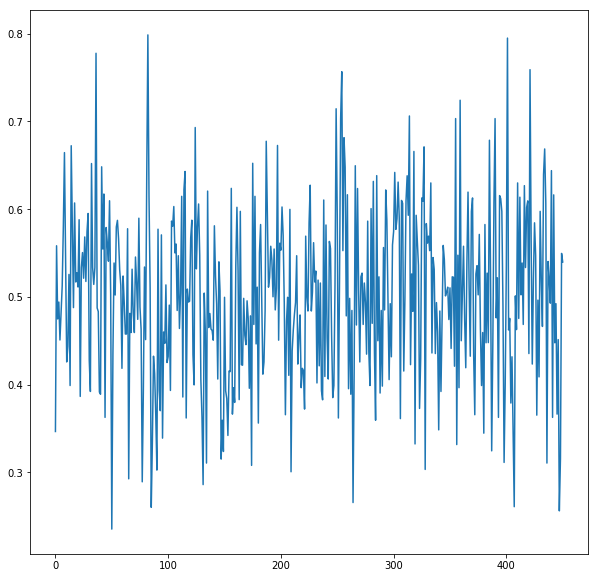

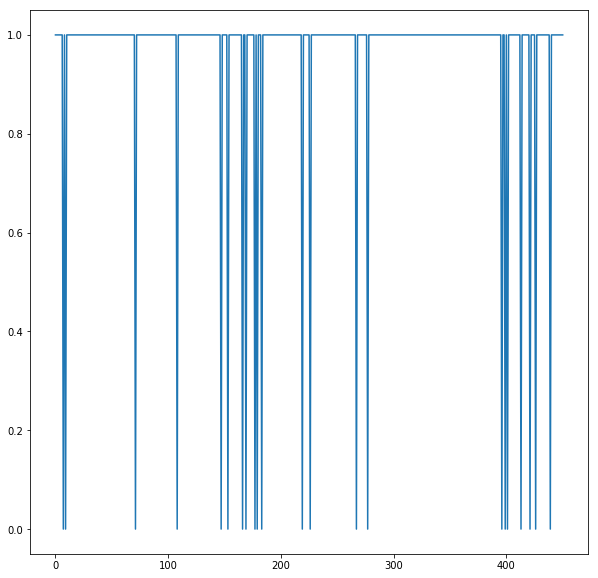

In [7]:
strategy_vector = strategy_vector.astype(float)

COST_OF_PRODUCTION = .01
CUTOFF = 3

def create_interaction_graph(distance_graph):
    
    distance_graph = np.asarray(distance_graph)
    distance_graph.reshape(len(vertices), len(vertices))
    print(type(distance_graph[0]))
    dg = [float("inf") if i > CUTOFF else i for e in distance_graph for i in e]
    assert(not(np.array_equal(dg, distance_graph)))
    
    distance_graph = np.asarray(dg)
    distance_graph = distance_graph.reshape(len(vertices), len(vertices))
    dg = [float("inf") if i == 0 else i for e in distance_graph for i in e]
    assert(not(np.array_equal(dg, distance_graph)))
    
    distance_graph = np.asarray(dg)
    distance_graph = distance_graph.reshape(len(vertices), len(vertices))
    interaction_graph = gf(distance_graph)
    assert(not(np.array_equal(interaction_graph, distance_graph)))
    
    return interaction_graph

interaction_graph = create_interaction_graph(distance_graph)


def calculate_benefit(interaction_graph):
    benefit_vector = []
    for i in range(len(vertices)):
        b = payoff_function(i, strategy_vector, interaction_graph)
        benefit_vector.append(b)
    return benefit_vector

def adjusted_benefit(interaction_graph):
    b = calculate_benefit(interaction_graph)
    for i in range(len(vertices)):
        b[i] = b[i] #- (COST_OF_PRODUCTION*strategy_vector[i])
    return b

b = adjusted_benefit(interaction_graph)
plt.plot(b)
plt.show()
plt.plot(strategy_vector)
plt.show()

##### Update Rules

As in Archetti, we establish a conditional imitation rule such that upon the death of a cell c_i, we only replace it with a random neighbor c_j if the benefit of c_j is greater than that of c_i

Other rules have been added in for future testing 

In [8]:
def conditional_imitation(strategy_vector, benefit_vector):
    update_number = randint(len(vertices))
    neighbors = np.nonzero(reproduction_graph[update_number])
    updator = neighbors[0][randint(len(neighbors))]
    if(benefit_vector[update_number] >= benefit_vector[updator]):
        return 0
    else:
        strategy_vector[update_number] = strategy_vector[updator]
        return 1
        
def unconditional_imitation(strategy_vector, benefit_vector):
    update_number = randint(len(vertices))
    neighbors = np.nonzero(reproduction_graph[update_number])
    updator = neighbors[0][randint(len(neighbors))]
    strategy_vector[update_number] = strategy_vector[updator]
    return 1

    
def stochastic_imitation(strategy_vector, benefit_vector):
    print("ERROR: Unimplimented Rule")
    
    
def best_imitation(strategy_vector, benefit_vector):
    update_number = randint(len(vertices))
    neighbors = np.nonzero(reproduction_graph[update_number])
    maxneighbor_payoff = -1
    best_neighbor = -1
    for i in neighbors[0]:
        if(benefit_vector[i] > benefit_vector[best_neighbor] ):
            best_neighbor = i
    strategy_vector[update_number] = strategy_vector[best_neighbor] 

### The parameters sheet

In each of the above blocks, several differetne parameters are establilshed to control the behavior of different functions. Here, we group them into one place. Running this code block determines the dynamic of the game to be played. 


##### Reveiw of parameter meanings:


* z_VALUE --> "controls the steepness of the gradient at the inflection point"
* d_VALUE --> "determine the shape of the diffusion gradient"
* D_VALUE --> "determine the shape of the diffusion gradient"
* n_VALUE --> depends on the diffusion range and gradient of the growth factor
* k_VALUE --> controls the position of the inflection point
* s_VALUE --> controls the steepness of the function at the inflection point
* CUTOFF --> The furthes a cell is allowed to feel another cell
* COST_OF_PRODUCTION --> how much each producing cell is penalized for contributing to the group



In [9]:
#===================================================
#      PARAMETERS SHEET - SEE EXPLANATION BELOW
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 3
D_VALUE = 6
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
COST_OF_PRODUCTION = .01
CUTOFF = 3
interaction_graph = create_interaction_graph(distance_graph)

<type 'numpy.ndarray'>


#### Running the game

Before we run the game, we create a few structures to track values throughout the playing of the game. 

number_of_producers --> tracks the number of producers in the graph. 

fitness_of_system --> tracks the cumulative benefit of the system

Playing the game consists of running the update rule, then calculating the benefit based on thew new strategies. The running of the game depends on which update rule you would like to use, the calculated interaction graph that has been calculated.



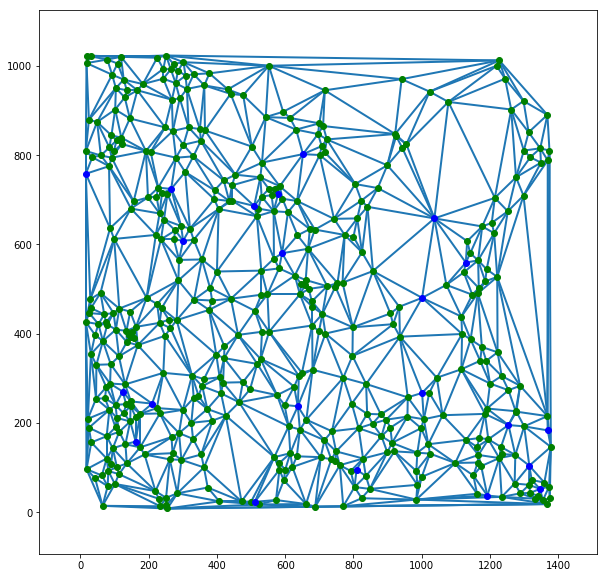

100%|██████████| 10000/10000 [01:13<00:00, 136.71it/s]


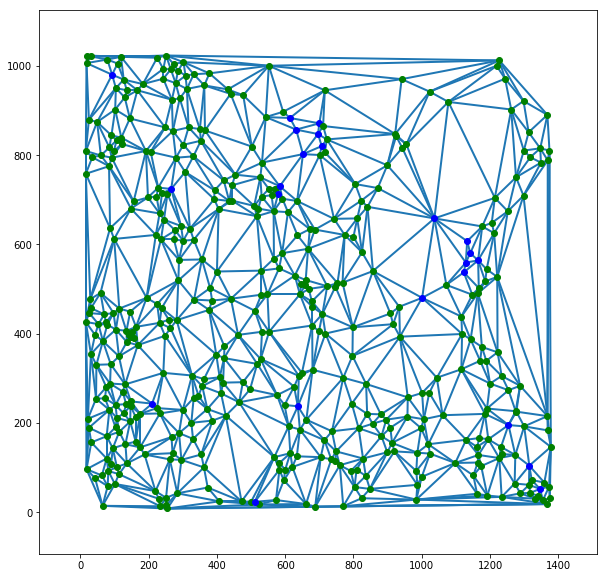

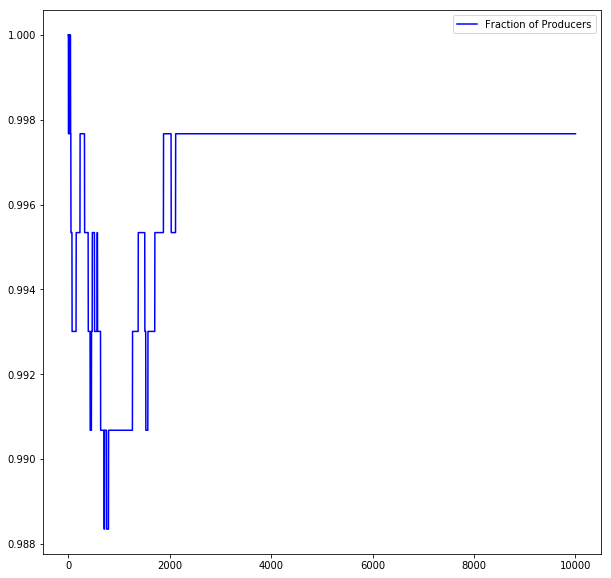

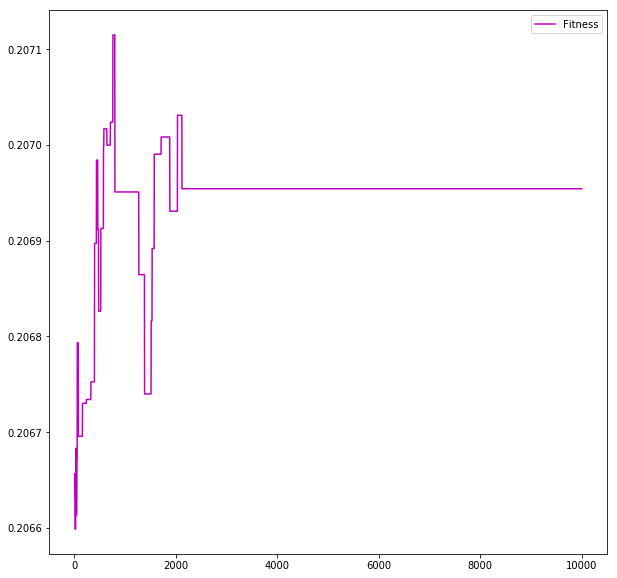

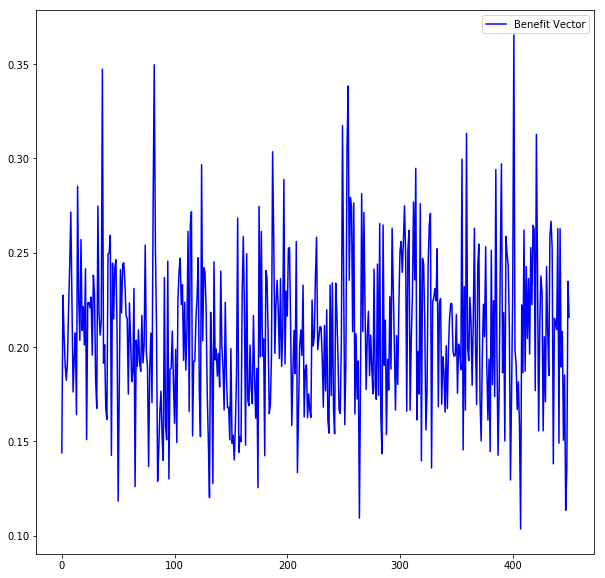

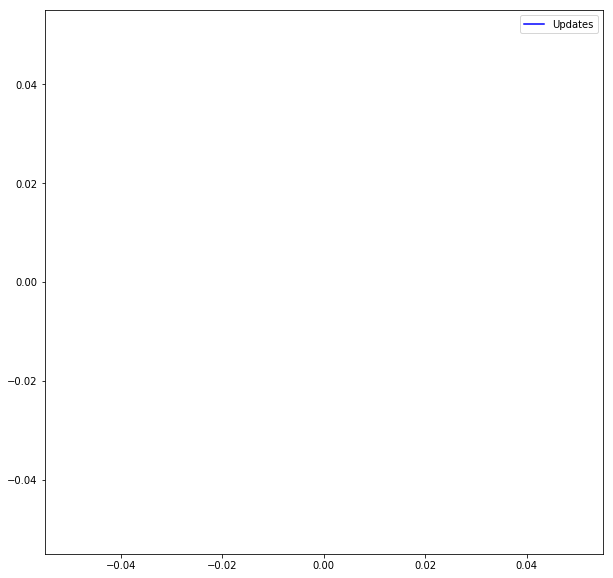

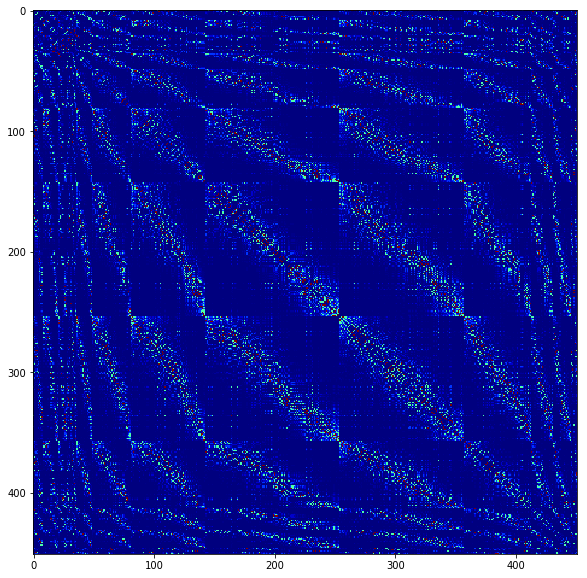

In [25]:
from tqdm import trange
#Global Structures:
# - reproduction_graph
# - distance_graph

strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)

number_of_producers = []
fitness_of_system = []
did_update = []

benefit_vector = adjusted_benefit(interaction_graph)
number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
fitness_of_system.append(sum(benefit_vector)/len(vertices))


def play_game(strategy_vector, update_rule, interaction_graph, iterations=10000):
    for i in trange(iterations):
        benefit_vector = adjusted_benefit(interaction_graph)
        du = update_rule(strategy_vector, benefit_vector)
        #did_update.append(du)
        number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
        fitness_of_system.append(sum(benefit_vector)/len(vertices))
        
        
display_graph(strategy_vector)
play_game(strategy_vector, conditional_imitation, interaction_graph)
display_graph(strategy_vector)

number_of_producers = np.asarray(number_of_producers)
number_of_producers= number_of_producers.astype(float)
number_of_producers /= np.max(number_of_producers)

plt.clf()
l1, = plt.plot(number_of_producers, label='Fraction of Producers', color='blue')
plt.legend(handles=[l1])
plt.show()

plt.clf()
l2, = plt.plot(fitness_of_system, label='Fitness', color='m')
plt.legend(handles=[l2])
plt.show()


plt.clf()
l1, = plt.plot(benefit_vector, label='Benefit Vector', color='blue')
plt.legend(handles=[l1])
plt.show()

plt.clf()
l1, = plt.plot(did_update, label='Updates', color='blue')
plt.legend(handles=[l1])
plt.show()

plt.clf()
plt.imshow(interaction_graph, cmap='jet', interpolation='nearest')
plt.show()

### 3.2/3.4 - Effects of costs and benefits

#### Archetti claims that for higher values of c (cost of production) and for higher values of d (group size) that cooperation decreases. 

Here, we will observe the affect of costs of production and different inflection points on the benefit function. We will start with the focal group range at 2, and then will run the tests at 4 and 6.

We will progressively increase the cost first and plot the affect it has on the fraction of producers.

Next, we will look at the effects of the inflection point of the benefit function on the fraction of producers.

See Archetti in Fig 4.

**It seems Archetti is inconsistant with notation and h=k**

**We will be using a sigmoid diffusion gradient in this test**

In [11]:
def run_game_return_producers():
    number_of_producers = []
    benefit_vector = adjusted_benefit(interaction_graph)
    number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
    
    def play_game(strategy_vector, update_rule, interaction_graph, iterations=5000):
        for i in trange(iterations):
            benefit_vector = adjusted_benefit(interaction_graph)
            update_rule(strategy_vector, benefit_vector)
            number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
    
    play_game(strategy_vector, conditional_imitation, interaction_graph)
    
    
    number_of_producers = np.asarray(number_of_producers)
    number_of_producers= number_of_producers.astype(float)
    number_of_producers /= np.max(number_of_producers)
    
    return number_of_producers

<type 'numpy.ndarray'>


100%|██████████| 5000/5000 [00:35<00:00, 139.15it/s]


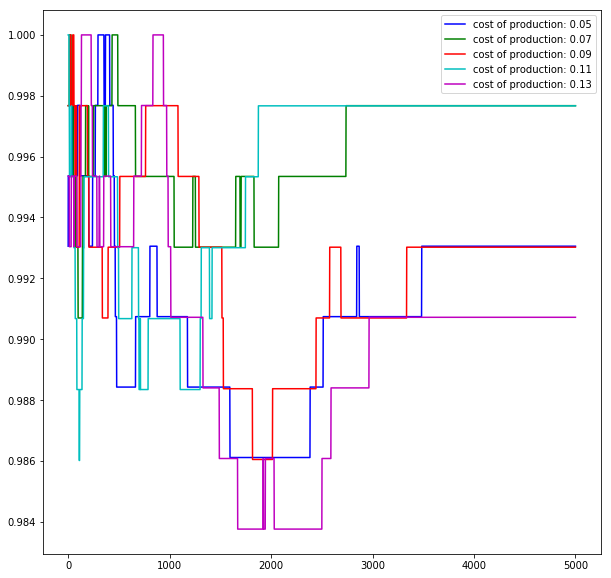

In [12]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 2
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 2
COST_OF_PRODUCTION = .05
interaction_graph = create_interaction_graph(distance_graph)


colors =['b', 'g', 'r', 'c', 'm']
producers = []
handles = []
for i in range(5):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "cost of production: %s"%(COST_OF_PRODUCTION)
    handle, = plt.plot(run_game_return_producers(), color=colors[i], label=l)
    handles.append(handle)
    COST_OF_PRODUCTION+=.02
plt.legend(handles=handles)
plt.show()  

#These results clearly make no sense. 

<type 'numpy.ndarray'>


100%|██████████| 5000/5000 [00:34<00:00, 144.74it/s]


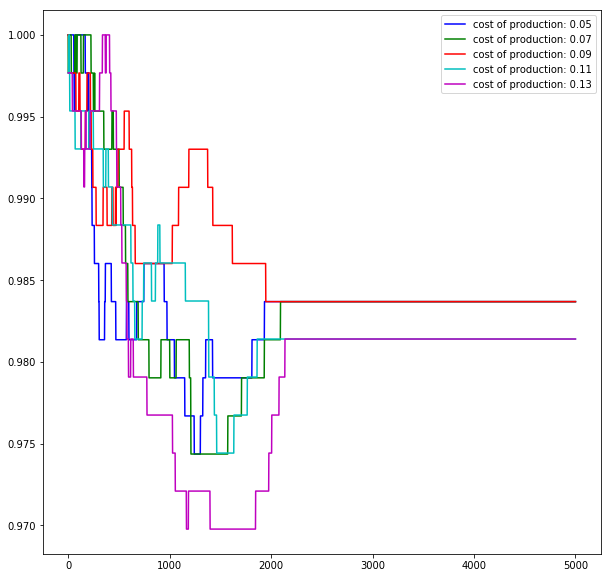

In [13]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 4
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 4
COST_OF_PRODUCTION = .05

interaction_graph = create_interaction_graph(distance_graph)

colors =['b', 'g', 'r', 'c', 'm']
producers = []
handles = []
for i in range(5):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "cost of production: %s"%(COST_OF_PRODUCTION)
    handle, = plt.plot(run_game_return_producers(), color=colors[i], label=l)
    handles.append(handle)
    COST_OF_PRODUCTION+=.02
plt.legend(handles=handles)
plt.show()  


<type 'numpy.ndarray'>


100%|██████████| 5000/5000 [00:36<00:00, 137.43it/s]


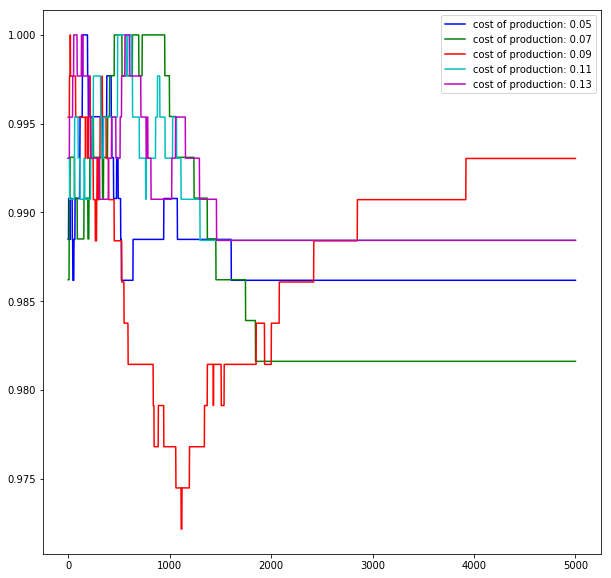

In [14]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 6
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .05

interaction_graph = create_interaction_graph(distance_graph)

colors =['b', 'g', 'r', 'c', 'm']
producers = []
handles = []
for i in range(5):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "cost of production: %s"%(COST_OF_PRODUCTION)
    handle, = plt.plot(run_game_return_producers(), color=colors[i], label=l)
    handles.append(handle)
    COST_OF_PRODUCTION+=.02
plt.legend(handles=handles)
plt.show()  


<type 'numpy.ndarray'>


100%|██████████| 5000/5000 [00:36<00:00, 145.70it/s]


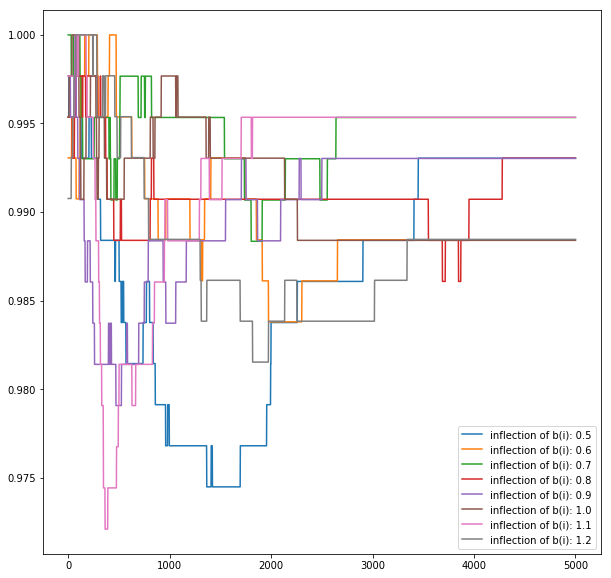

In [15]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 2
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
n_VALUE =  1#6 * d_VALUE #number of people in the group * the cutoff
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 2
COST_OF_PRODUCTION = .05

interaction_graph = create_interaction_graph(distance_graph)

producers = []
handles = []
for i in range(8):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "inflection of b(i): %s"%(k_VALUE)
    handle, = plt.plot(run_game_return_producers(), label=l)
    handles.append(handle)
    k_VALUE += .1
plt.legend(handles=handles)
plt.show() 

<type 'numpy.ndarray'>


100%|██████████| 5000/5000 [00:36<00:00, 135.48it/s]


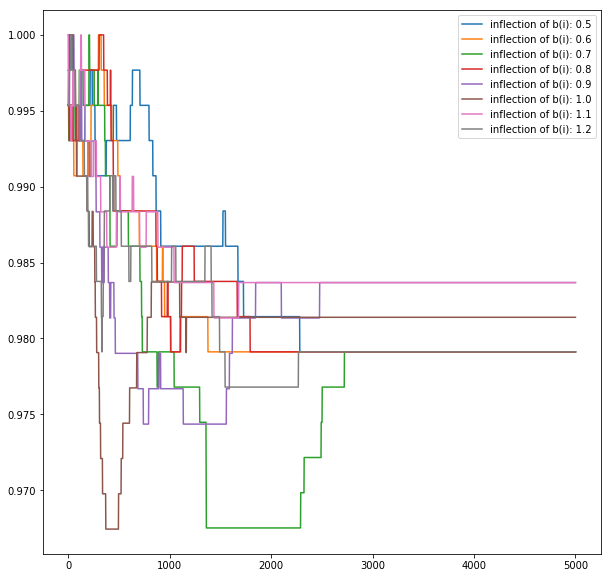

In [16]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 4
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 4
COST_OF_PRODUCTION = .05

interaction_graph = create_interaction_graph(distance_graph)

producers = []
handles = []
for i in range(8):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "inflection of b(i): %s"%(k_VALUE)
    handle, = plt.plot(run_game_return_producers(), label=l)
    handles.append(handle)
    k_VALUE += .1
plt.legend(handles=handles)
plt.show() 

<type 'numpy.ndarray'>


100%|██████████| 5000/5000 [00:39<00:00, 137.94it/s]


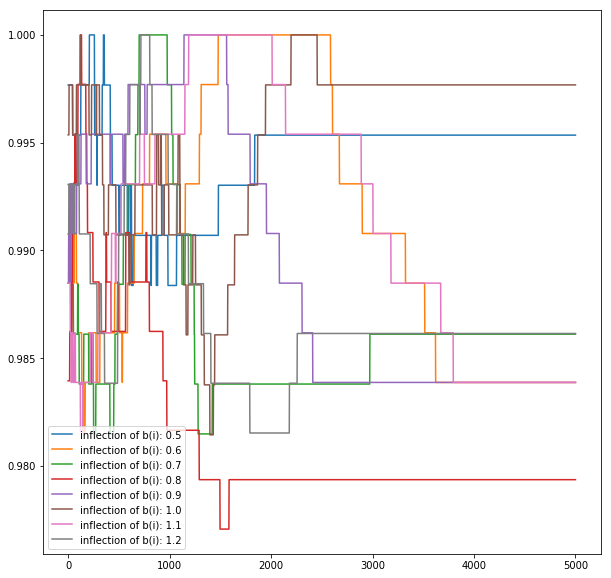

In [17]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 6
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .5
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .05

interaction_graph = create_interaction_graph(distance_graph)

producers = []
handles = []
for i in range(8):
    strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
    l = "inflection of b(i): %s"%(k_VALUE)
    handle, = plt.plot(run_game_return_producers(), label=l)
    handles.append(handle)
    k_VALUE += .1
plt.legend(handles=handles)
plt.show() 

### 3.3 - Effects of diffusion gradients

We will try to replicate each of the values given by Archetti in Fig 7. :

*"(a) Fixed diffusion range with no diffusion gradient (d=3, D=6, z=1000). (b) Sigmoid diffusion gradient (d=3, D=6, z=10). (c) Linear diffusion gradient (d=3, D=6, z=1). (d) Concave diffusion gradient (d=0, D=7, z=3)."*

In [18]:
def run_game_with_output():
    number_of_producers = []
    fitness_of_system = []
    benefit_vector = adjusted_benefit(interaction_graph)
    number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
    fitness_of_system.append(sum(benefit_vector)/len(vertices))
    def play_game(strategy_vector, update_rule, interaction_graph, iterations=3000):
        for i in trange(iterations):
            benefit_vector = adjusted_benefit(interaction_graph)
            update_rule(strategy_vector, benefit_vector)
            number_of_producers.append(len(np.nonzero(strategy_vector)[0]))
            fitness_of_system.append(sum(benefit_vector)/len(vertices))
    play_game(strategy_vector, conditional_imitation, interaction_graph)
    display_graph(strategy_vector)
    
    number_of_producers = np.asarray(number_of_producers)
    number_of_producers= number_of_producers.astype(float)
    number_of_producers /= np.max(number_of_producers)

    plt.clf()
    l1, = plt.plot(number_of_producers, label='Fraction of Producers', color='blue')
    l2, = plt.plot(fitness_of_system, label='Fitness', color='m')
    plt.legend(handles=[l1,l2])
    plt.show()

<type 'numpy.ndarray'>


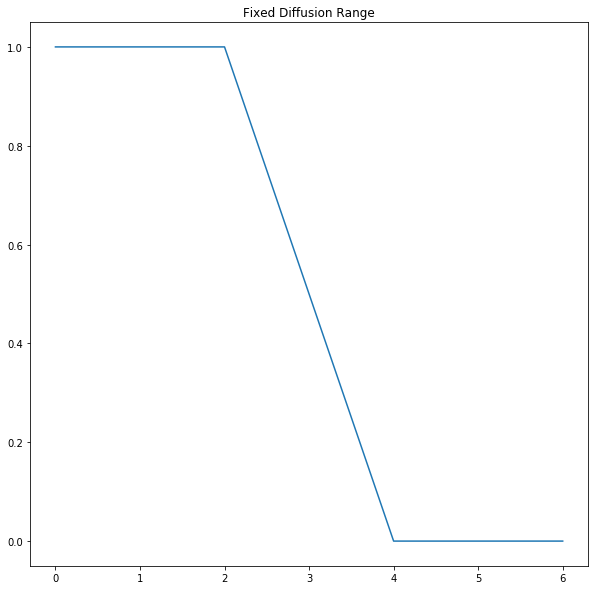

100%|██████████| 3000/3000 [00:25<00:00, 118.11it/s]


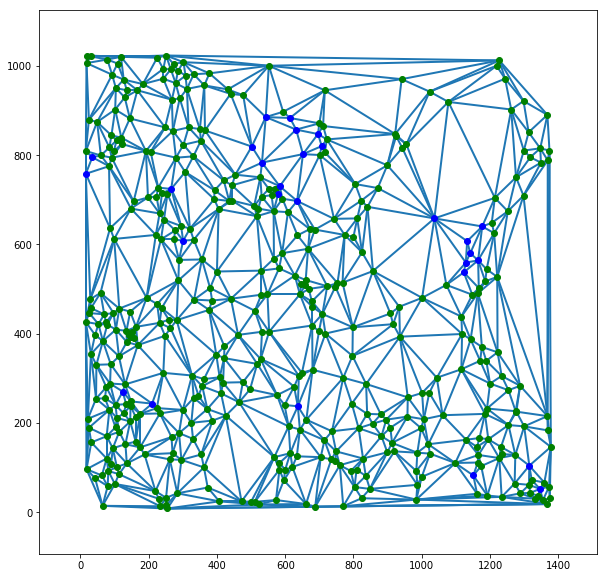

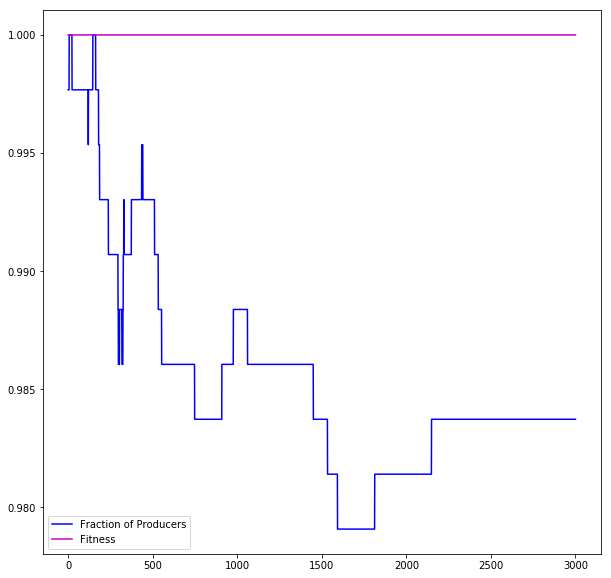

In [19]:
#===================================================
#      PARAMETERS SHEET - No Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 1000
d_VALUE = 3
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2

interaction_graph = create_interaction_graph(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Fixed Diffusion Range")
plt.show()
run_game_with_output()

<type 'numpy.ndarray'>


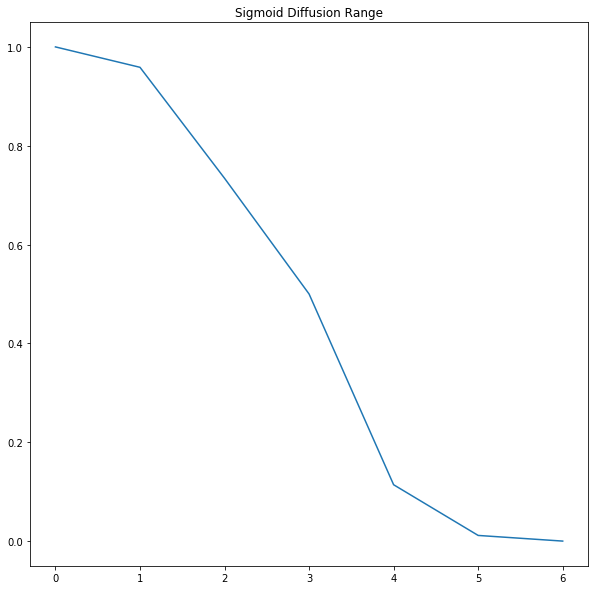

100%|██████████| 3000/3000 [00:29<00:00, 102.39it/s]


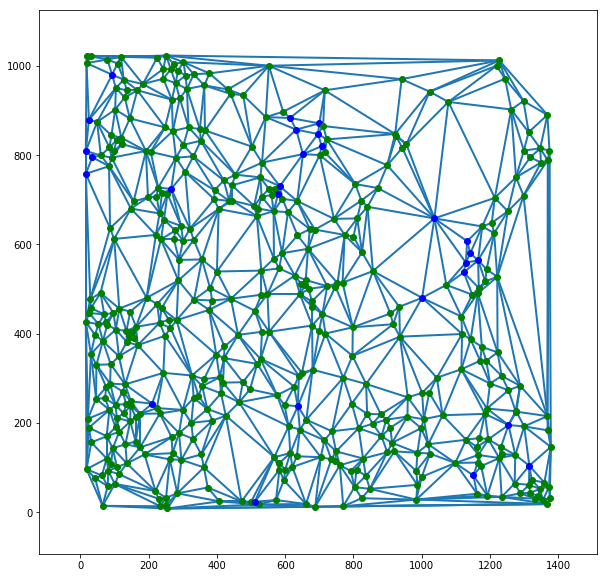

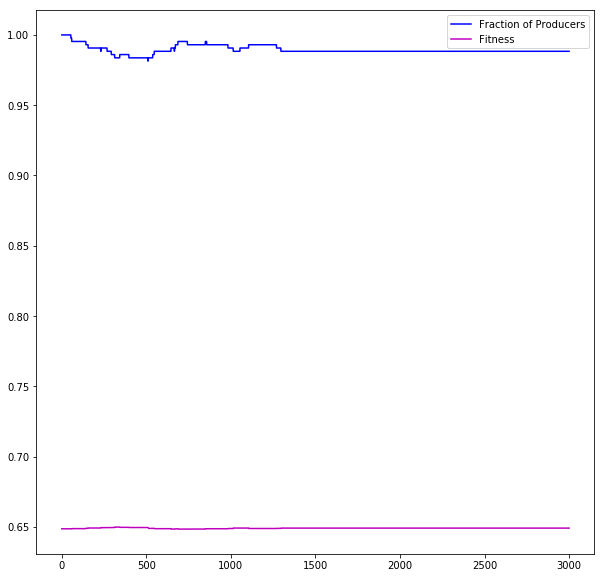

In [20]:
#===================================================
#      PARAMETERS SHEET - Sigmoid Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 10
d_VALUE = 3
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2

interaction_graph = create_interaction_graph(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Sigmoid Diffusion Range")
plt.show()
run_game_with_output()

<type 'numpy.ndarray'>


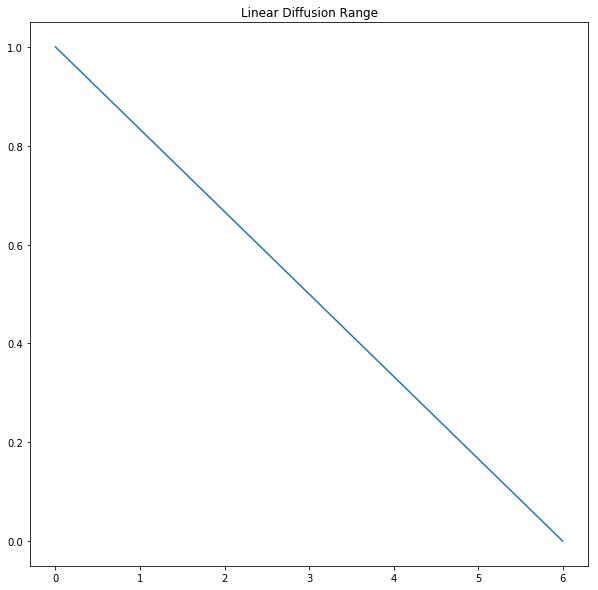

100%|██████████| 3000/3000 [00:23<00:00, 125.84it/s]


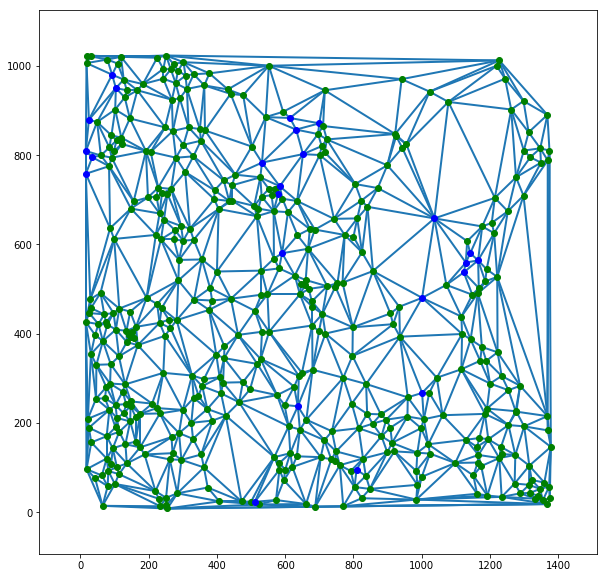

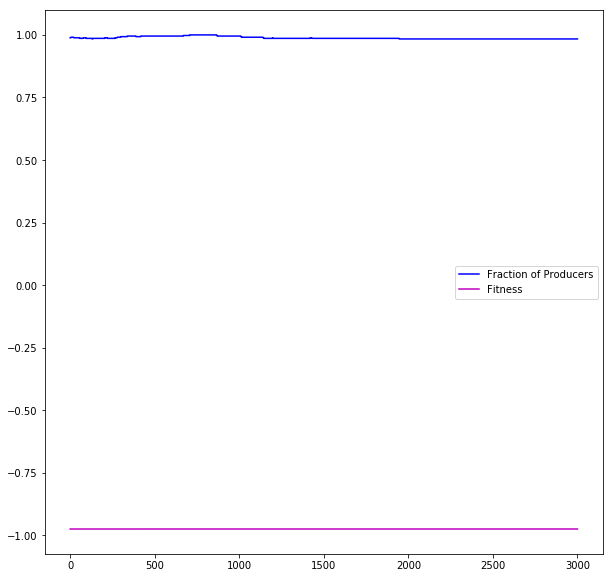

In [21]:
#===================================================
#      PARAMETERS SHEET - Linear Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = .1
d_VALUE = 3
D_VALUE = 6
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2

interaction_graph = create_interaction_graph(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Linear Diffusion Range")
plt.show()
run_game_with_output()

<type 'numpy.ndarray'>


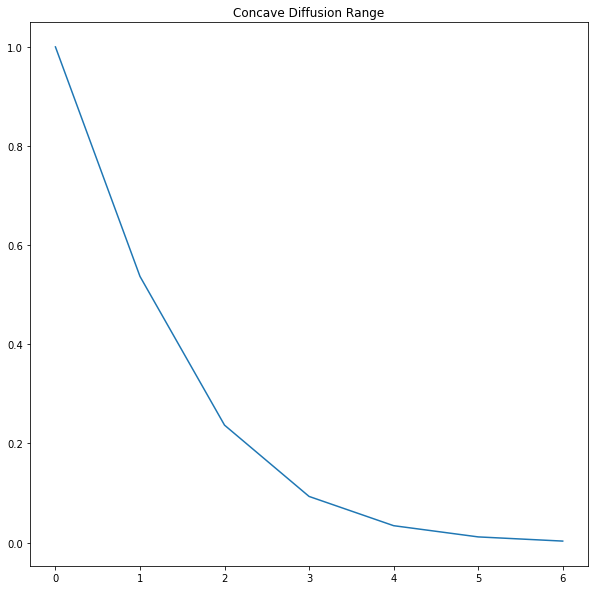

100%|██████████| 3000/3000 [00:23<00:00, 129.32it/s]


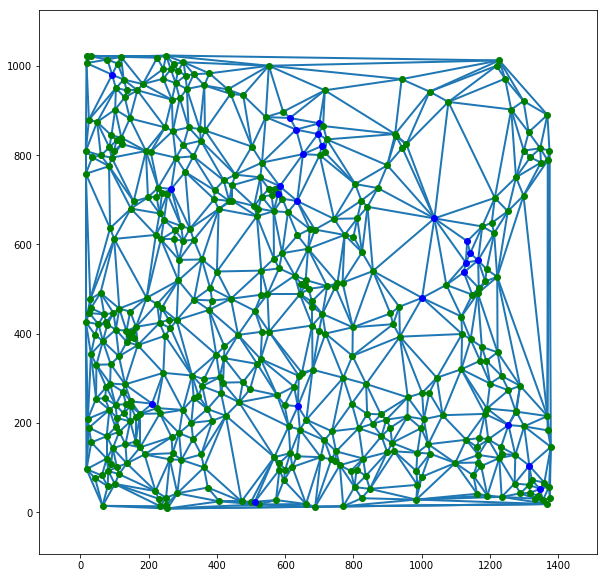

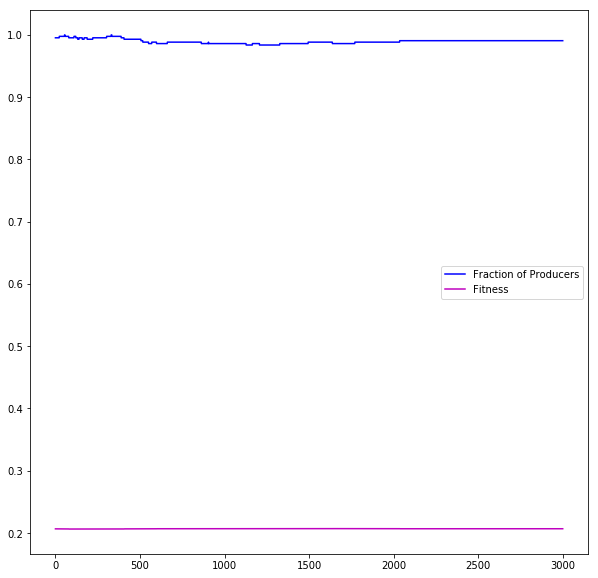

In [22]:
#===================================================
#      PARAMETERS SHEET - Concave Diffusion Gradient
#===================================================
strategy_vector = np.copy(ORIGINAL_STRATEGY_VECTOR)
z_VALUE = 7
d_VALUE = 0
D_VALUE = 7
def g(i, z = z_VALUE, d = d_VALUE, D = D_VALUE):
    valA = (-z*(i-d))/D
    exp = math.exp(1)**valA
    return 1/(1 + exp)
gf = np.vectorize(gradient_function)
s_VALUE = 20
k_VALUE = .1
distance_graph = scipy.sparse.csgraph.floyd_warshall(reproduction_graph, directed=False, 
                                                     return_predecessors=False, unweighted=True,
                                                     overwrite=False)
CUTOFF = 6
COST_OF_PRODUCTION = .2

interaction_graph = create_interaction_graph(distance_graph)

value = []
for i in range(7):
    value.append(gf(i))
plt.clf()
plt.plot(value)
plt.title("Concave Diffusion Range")
plt.show()
run_game_with_output()

# Conclusion: the implimentation of the benefit function is incorrect.